## Implement word embeddings using CBOW from scratch

### Import libs and data

In [1]:
import torch
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = load_dataset('imdb')
train_data = dataset['train']
test_data = dataset['test']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[12500 12500]


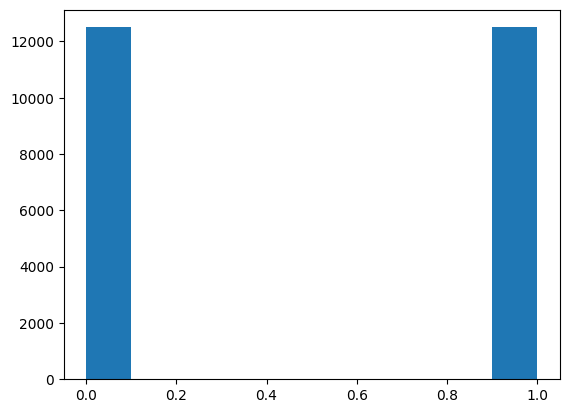

In [3]:
labels, counts = np.unique(train_data['label'], return_counts=True)
print(counts)
plt.hist(train_data['label'])
plt.show()

#### constants for cbow

In [4]:
UNKNOWN_TOKEN = '<UNK>'
PADDING_TOKEN = '<PAD>'
BATCH_SIZE = 4096
MIN_FREQUENCY = 5
WINDOW_SIZE = 2

#### tokenize text



In [5]:
import re
from collections import Counter
def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

words = tokenize(' '.join(train_data['text']))

#### Create vocabs

In [6]:
def create_vocabs(words, min_frequency=5, pad_token='<PAD>', unk_token='<UNK>'):
    words_counts = Counter(words)
    word2idx = {unk_token: 0, pad_token: 1}
    idx2word = {0: unk_token, 1: pad_token}
    idx = 2
    for word, count in words_counts.items():
        if count> min_frequency:
            word2idx[word] = idx
            idx2word[idx] = word
            idx += 1
    return word2idx, idx2word

word2idx, idx2word = create_vocabs(words, min_frequency=MIN_FREQUENCY, pad_token=PADDING_TOKEN, unk_token=UNKNOWN_TOKEN)

#### Create pairs

In [7]:
def get_cbow_pairs(words, window_size=2):
    pairs = []
    n = len(words)
    for i in range(n):
        central_word = words[i] if words[i] in word2idx else UNKNOWN_TOKEN
        if central_word not in word2idx:
            central_word = UNKNOWN_TOKEN

        # fill context
        context = []
        for j in range(i - window_size, i + window_size + 1):
            context_word = PADDING_TOKEN
            if j >= 0 and j < n and j != i:
                context_word = words[j] if words[j] in word2idx else UNKNOWN_TOKEN
            context.append(word2idx[context_word])

        pairs.append((context, word2idx[central_word]))

    return pairs

cbow_pairs = get_cbow_pairs(words, window_size=WINDOW_SIZE)

#### Make dataset from pairs

In [8]:
from torch.utils.data import Dataset, DataLoader
class CBOWDataset(Dataset):
    def __init__(self, pairs):
        super().__init__()
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        context, central_word = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(central_word, dtype=torch.long)

cbow_dataset = CBOWDataset(cbow_pairs)
train_cbow_dataloader = DataLoader(cbow_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Implement CBOW

In [9]:
from torch import nn
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, pad_idx=None):
        super().__init__()
        # self.context_embeddings = torch.randn(vocab_size, embedding_dim, requires_grad=True)
        # self.central_embeddings = torch.randn(vocab_size, embedding_dim, requires_grad=True)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.central_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

    def forward(self, contexts_batch):
          context_vectors = self.context_embeddings(contexts_batch).mean(dim=1)
          logits = context_vectors @ self.central_embeddings.weight.T
          return logits


# working via collab
gpu_t4 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cbow = CBOW(len(word2idx), pad_idx=word2idx[PADDING_TOKEN]).to(gpu_t4)

#### Train CBOW

In [10]:
# for contexts_batch, central_words_batch in dataloader:
#     contexts_batch = contexts_batch.to(gpu_t4)
#     central_words_batch = central_words_batch.to(gpu_t4)
#     cbow.forward(contexts_batch)
#     break

def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X,y = X.to(gpu_t4), y.to(gpu_t4)
    pred = model(X)
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 20 == 0:
      loss, current = loss.item(), batch * BATCH_SIZE + len(X)
      print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

##### make test data (make pipeline)

In [11]:
def preprocess_input_cbow(text):
  words = tokenize(text)
  pairs = get_cbow_pairs(words, window_size=WINDOW_SIZE)
  dataset = CBOWDataset(pairs)
  dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
  return dataloader

In [15]:
test_cbow_dataloader = preprocess_input_cbow(' '.join(test_data['text']))
cbow_loss_fn = nn.CrossEntropyLoss()
cbow_optimizer = torch.optim.SGD(cbow.parameters(), lr=1e-2, momentum=0.8)
for epoch in range(10):
  print(f'\n\n\n---------------------EPOCH {epoch}------------------\n')
  train_loop(train_cbow_dataloader, cbow, cbow_loss_fn, cbow_optimizer)




---------------------EPOCH 0------------------

loss: 16.537220 [ 4096/6056873]
loss: 16.489592 [86016/6056873]
loss: 16.596195 [167936/6056873]
loss: 16.539494 [249856/6056873]
loss: 16.462257 [331776/6056873]
loss: 16.484463 [413696/6056873]
loss: 16.540308 [495616/6056873]
loss: 16.420076 [577536/6056873]
loss: 16.221577 [659456/6056873]
loss: 16.518135 [741376/6056873]
loss: 16.366102 [823296/6056873]
loss: 16.362553 [905216/6056873]
loss: 16.263205 [987136/6056873]
loss: 16.329477 [1069056/6056873]
loss: 16.314667 [1150976/6056873]
loss: 16.298115 [1232896/6056873]
loss: 16.354805 [1314816/6056873]
loss: 16.273624 [1396736/6056873]
loss: 16.415398 [1478656/6056873]
loss: 16.274088 [1560576/6056873]
loss: 16.188766 [1642496/6056873]
loss: 16.172625 [1724416/6056873]
loss: 16.212864 [1806336/6056873]
loss: 16.302464 [1888256/6056873]
loss: 16.316729 [1970176/6056873]
loss: 16.168310 [2052096/6056873]
loss: 16.183645 [2134016/6056873]
loss: 16.166857 [2215936/6056873]
loss: 16.093